In [2]:
import numpy as np
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dataclasses import dataclass,field
from typing import Optional, Dict
from tqdm import tqdm
import seaborn as sns
import os
import shutil
import math
from concurrent.futures import ProcessPoolExecutor
from joblib import Parallel, delayed
from matplotlib import rcParams
# 设置中文字体
rcParams['font.sans-serif'] = 'Heiti TC'  # 常用的中文字体，SimHei是黑体
rcParams['axes.unicode_minus'] = False  # 解决负号显示为乱码的问题




In [3]:
# 输出当前字体设置
rcParams['font.sans-serif'] = 'Heiti TC'
print("Current font family:", rcParams['font.sans-serif'])

Current font family: ['Heiti TC']


In [4]:
def process_stock_universe(index_name,data_a):
    data_a.index.name = 'stock_code'

    if index_name in ['ZZ500', 'ZZ800']:
        zz500_stocks = ak.index_stock_cons_csindex(symbol="000905")
        zz500_stocks['code'] = zz500_stocks['成分券代码'].apply(lambda x: f"{x}.{'XSHG' if x.startswith('6') else 'XSHE'}")
        zz500_stock_list = zz500_stocks['code'].values
        
    if index_name in ['HS300', 'ZZ800']:
        hs300_stocks = ak.index_stock_cons_sina(symbol='000300')
        hs300_stocks['code'] = hs300_stocks['code'].apply(lambda x: f"{x}.{'XSHG' if x.startswith('6') else 'XSHE'}")
        hs300_stock_list = hs300_stocks['code'].values

    if index_name == 'ZZ500':
        stock_list = zz500_stock_list
    elif index_name == 'HS300':
        stock_list = hs300_stock_list
    elif index_name == 'ZZ800':
        stock_list = list(set(zz500_stock_list)|set(hs300_stock_list))
    else:
        stock_list = data_a.index if index_name == 'A' else None
    # 如果是A股市场数据就不筛选，否则按股票筛选
    df = data_a if index_name == 'A' else data_a.loc[stock_list]
    df = df.reset_index()
    # 生成 close 和 open 数据框，并移除列名
    df_close = df.pivot(index='date', columns='stock_code', values='close')
    df_open = df.pivot(index='date', columns='stock_code', values='open')
    df_close.columns.name = df_open.columns.name = None


    return df_close, df_open

In [5]:
data_a = pd.read_csv('../data/a_close.csv',index_col = [0])

In [6]:
df_close = process_stock_universe('A',data_a)[0]

In [7]:
df_lstm = pd.read_csv('df_lstm.csv',parse_dates = ['date'],index_col = ['date','stock_code'])

In [8]:
#回测框架
#df2是每个股票的开盘价？？？
#参数是df1，df3，指数名如HS300
#指数收益率df4 index是date 列名是
#df1是每个股票的收盘价
#调仓的df3：双索引 level0是date level1是stock_code value是权重 调仓频率包含在里面 一行的信息是level0索引时间的
#我是一个researcher同时也是一个量化交易员
#有一个字典记录我在每支股票上的持仓
#我还有几个属性就是 cash（可用现金） value（总价值=cash+股票持仓之和）
#可以有多个researcher同时在循环中
#买股票的时候当然只能用cash啦
#回测是一个for循环（对df3的level0索引唯一值遍历）  买卖价格都是收盘价
#交易逻辑只设置一个就是target 把我在某只股票上的权重（比例）调整为目标值
#这样的话我会计算我要买多少卖多少 可以log下来
#这样的话计算手续费就方便了
#一个循环中 时间是：current=df3.index.get_level_values(0) 我要调用的有：df3的current子df df1的current行 
#要输入： 股票池index_name  
#调仓的df：双索引df level0是date level1是stock_code value是权重 调仓频率包含在里面
#手续费需要每次调仓计算 ，分为：双向佣金默认0.0003 卖出印花税0.001 所以每一步要考虑两行数据 no 一行就够了
#每一个循环中我要记录的有： value 
#定义一个函数可以可视化我的value曲线 以及累积超额
#循环结束后 运行上面的函数 
#如果可以的话设计一个ic模式 这个模式为True的话 输入的df3的value就是因子值 
#然后每天分层（层数num_layer是参数） 有num_layer个researcher 每个researcher选择对应的层的股票等权配置 这样每个researcher都有一个权重df
#然后ic模式下统一到一起对比输出因子ic icir 分层收益等等 #ic_mode拿出来单独写
#可以选择是否考虑开盘价 所以每次买入是用开盘价 不考虑开盘价就用收盘价df.shift(1)代替开盘价df？？？


In [175]:
import cvxpy as cp
import numpy as np

class PortfolioOptimizer:
    def __init__(self, close_df: pd.DataFrame, rebalance_df: pd.DataFrame, benchmark_close: Optional[pd.DataFrame] = None,risk_aversion: float = 1.0):
        self.close_df = close_df  # 单索引 为date 列名为很多股票代码
        self.rebalance_df = rebalance_df  # 双层索引 level0是date level1是stock_code 列名为factor 只有一列
        self.benchmark_close = benchmark_close  # 单索引 为date 列名为close
        self.risk_aversion = risk_aversion

        

    def choose_stocks(self, percent: float = None, num: int = None):
        if percent is not None:
            assert 0 < percent <= 1, "Percent must be between 0 and 1"
        if num is not None:
            assert num > 0, "Num must be greater than 0"
        
        def assign_weights(group):
        
            if percent is not None:
                threshold = int(len(group) * percent)
            else:
                threshold = num
            top_stocks = group.nlargest(threshold, 'factor')
            group['weight'] = 0
            group.loc[top_stocks.index, 'weight'] = 1
            group = group.reset_index(level=0, drop=True)
            
            return group
        '''idx = self.rebalance_df.index'''
        
        self.rebalance_df = self.rebalance_df.groupby(level = 'date').apply(assign_weights)
        '''self.rebalance_df.index = idx'''


    def optimize_weight(self, target: str, weight_bounds: tuple = (0, 1), regularization=None, count: int = 250):
        
        count = min(count, len(self.close_df),len(self.benchmark_close))
        """
        优化投资组合权重
        Args:
            target: 优化目标 ('EqualWeight', 'MinVariance', 'MaxSharpeRatio' etc.)
            weight_bounds: 权重上下限
            regularization: 正则化参数
            count: 计算协方差矩阵使用的历史数据长度
        """
        def calculate_covariance_matrix(returns):
            return returns.cov().values  # 转换为numpy数组
        
        def calculate_expected_returns(returns):
            return returns.mean().values  # 转换为numpy数组
        
        def optimize_for_date(date, selected_stocks,regularization):
            
            # 获取历史收益率
            returns = self.close_df[selected_stocks].pct_change().bfill().dropna()
            if len(returns) > count:
                returns = returns.iloc[-count:]
            
            cov_matrix = calculate_covariance_matrix(returns)
            expected_returns = calculate_expected_returns(returns)



            
            if self.benchmark_close is not None:
                benchmark_returns = self.benchmark_close.pct_change().bfill().dropna()
                if len(benchmark_returns) > count:
                    benchmark_returns = benchmark_returns.iloc[-count:]
                benchmark_returns = benchmark_returns.reindex(returns.index).dropna()
                benchmark_mean = benchmark_returns.mean()
            else:
                benchmark_mean = 0.0
            
            n = len(selected_stocks)
            w = cp.Variable(n)

            if regularization is None:
                # 根据资产数量自动调整
                num_assets = len(expected_returns)
                regularization = 0.1 / num_assets
            gamma = cp.Parameter(nonneg=True)
            gamma.value = regularization

        
            
            constraints = [cp.sum(w) == 1, w >= weight_bounds[0], w <= weight_bounds[1]]
            
            if target == 'MinVariance':
                objective = cp.Minimize(cp.quad_form(w, cov_matrix) + gamma * cp.norm(w, 2))
            elif target == 'MaxProfit':
                objective = cp.Maximize(expected_returns @ w - gamma * cp.norm(w, 2))
            elif target == 'MaxSharpeRatio':
                portfolio_return = expected_returns @ w
                portfolio_variance = cp.quad_form(w, cov_matrix)
                objective = cp.Maximize(
                    portfolio_return - 
                    (self.risk_aversion / 2) * portfolio_variance - 
                    gamma * cp.norm(w, 2)
                )
            elif target == 'MinTrackingError':
                tracking_error = cp.norm(returns @ w - benchmark_returns.values, 2)
                objective = cp.Minimize(tracking_error + gamma * cp.norm(w, 2))
            elif target == 'RiskParity':
                # 计算资产的风险贡献
                portfolio_variance = cp.quad_form(w, cov_matrix)
                marginal_contrib = cp.multiply(cov_matrix @ w, w)
                risk_contrib = marginal_contrib

                # 定义风险贡献的均值
                avg_contrib = portfolio_variance / n

                # 最小化风险贡献与平均风险贡献的差异（平方和）
                objective = cp.Minimize(
                    cp.sum_squares(risk_contrib - avg_contrib) + gamma * cp.norm(w, 2)
                )
            elif target == 'EqualWeight':
                objective = cp.Minimize(cp.norm(w - (1/n) * np.ones(n), 2))
            elif target == 'MeanVarianceUtility':
                 # 确保分母不为零
                portfolio_return = expected_returns @ w
                portfolio_risk = cp.quad_form(w, cov_matrix)
                objective = cp.Maximize(portfolio_return - (self.risk_aversion/2)* (portfolio_risk) - gamma * cp.norm(w, 2))
            else:
                raise ValueError("Unknown optimization target")
            
            problem = cp.Problem(objective, constraints)
            try:
                problem.solve()
                if w.value is None:
                    raise ValueError("Optimization failed")
                return w.value
            except Exception as e:
                print(f"[WARNING] Optimization failed for date {date}. Using equal weight instead. Error: {str(e)}")
                return np.ones(n) / n
    
    

        for date in self.rebalance_df.index.get_level_values(0).unique():
            # 获取当前日期的股票
            date_slice = self.rebalance_df.xs(date, level=0)
            selected_stocks = date_slice[date_slice['weight'] == 1].index.tolist()
            
            if len(selected_stocks) > 0:
                 # 对每个日期进行优化
                optimized_weights = optimize_for_date(date, selected_stocks,regularization)
            
                # 更新权重 - 使用reindex确保索引对齐
                idx = pd.MultiIndex.from_product([[date], selected_stocks], names=['date', 'stock_code'])
                
                self.rebalance_df.loc[idx, 'weight'] = optimized_weights


In [ ]:
@dataclass
class Simultrading:
    # 定义数据类中的字段
    #date要求为标准形式
    start_date:str = None 
    end_date:str = None
    stamp_duty: float = 0.0  # 卖出手续费 印花税万分之5 默认不考虑手续费
    brokerage_commission: float = 0.0  # 券商佣金假设为万分之3 默认不考虑
    start_value: float = 1e+10  # 初始资金
    rebalance_df: Optional[pd.DataFrame] = field(default_factory=pd.DataFrame)  # 调仓数据 #要求双层索引 level0为‘date’ level1为‘stock_code' 列名为‘factor’，‘weight’ 
    #value值为计算出的预测值 用来计算ic weight值为调仓目标权重 支持对组合进行优化 后面加
    benchmark: str = 'HS300'  # 基准
    close_df: Optional[pd.DataFrame] = field(default_factory=pd.DataFrame)   # 股票收盘价数据 要求列名形式为'000000.XSHG'（与rebalance_df保持一致） index为‘date’ 建议后向填充一下 不填充的话更真实
    strategy_name: str = 'lstm'
    optimization: Dict = field(
        default_factory=lambda: {
            'target': 'EqualWeight',
            'regularization': None,
            'percent': 0.1,
            'num': None,
            'count': 250,
            'weight_bounds': (0, 1),
            'risk_aversion': 1.0
        }
    )
    #止盈损的参数 例如：{'method':'fixed_ratio','up_pct':0.15,'down_pct':0.05}  method为止盈损的方法 count为止盈损的比例
    TP_SL: Dict = field(
        default_factory=lambda: {
            'method': None,
            'count': 20,
            'up_pct': 0.15,
            'down_pct': 0.05,
            'window_short':10,
            'window_long':50

        }
    )
    def __post_init__(self):
        # 合并用户提供的优化参数和默认值
        default_optimization = {
            'target': 'EqualWeight',
            'regularization': 0.0,
            'percent': 0.1,
            'num': None,
            'count': 250,
            'weight_bounds': (0, 1),
            'risk_aversion': 1.0
        }
        if isinstance(self.optimization, dict):
            self.optimization = {**default_optimization, **self.optimization}

        # 合并用户提供的优化参数和默认值
        default_TP_SL =  {
            'method': None,
            'count': 250,
            'up_pct': 0.15,
            'down_pct': 0.05,
            'window_short':10,
            'window_long':50

        }
        if isinstance(self.TP_SL, dict):
            self.TP_SL = {**default_TP_SL, **self.TP_SL}
            
            
        self.initialize_data()
        self.prepare_backtest()
        if 'weight' not in self.rebalance_df.columns:
            self.optimize_portfolio()
            print('[INFO] 已完成组合优化')
        if self.TP_SL['method'] is 'ma':
            self.ma_df_short = self.close_df.rolling(window = self.TP_SL['window_short']).mean().shift(1)
            self.ma_df_long = self.close_df.rolling(window = self.TP_SL['window_long']).mean().shift(1)
    
    def optimize_portfolio(self):
        optimizer = PortfolioOptimizer(self.close_df, self.rebalance_df,self.index_close,self.optimization['risk_aversion'])
        if self.optimization['percent'] is not None:
            optimizer.choose_stocks(percent=self.optimization['percent'])  # Example: select top 10% stocks
        else:
            optimizer.choose_stocks(num=self.optimization['num'])
        optimizer.optimize_weight(target=self.optimization['target'],count = self.optimization['count'],weight_bounds = self.optimization['weight_bounds'],
                                    regularization = self.optimization['regularization'])  # Example: optimize for maximum Sharpe ratio
        self.rebalance_df = optimizer.rebalance_df

    def initialize_data(self):
        # 确保索引格式正确
        if not isinstance(self.rebalance_df.index, pd.MultiIndex):
            raise ValueError("rebalance_df must have MultiIndex")
            
        # 确保日期格式正确
        self.close_df.index = pd.to_datetime(self.close_df.index)
        self.rebalance_df = self.rebalance_df.copy()
        self.rebalance_df.index = pd.MultiIndex.from_arrays([
            pd.to_datetime(self.rebalance_df.index.get_level_values(0)),
            self.rebalance_df.index.get_level_values(1)
        ])
        self.rebalance_df = self.rebalance_df.dropna()
        self.dates = self.rebalance_df.index.get_level_values(0).unique()
        # 如果 start_date 或 end_date 为 None，设置为默认日期范围的起始或结束日期
        self.start_date = pd.to_datetime(self.start_date) if self.start_date is not None else self.dates[0]
        self.end_date = pd.to_datetime(self.end_date) if self.end_date is not None else self.dates[-1]

        # 设置 start_date 和 end_date 的有效范围
        self.start_date = self.start_date if self.start_date >= self.dates[0] else self.dates[0]
        self.end_date = self.end_date if self.end_date <= self.dates[-1] else self.dates[-1]
        self.total_dates = self.close_df.index.unique()
        self.total_dates = self.total_dates[(self.total_dates >= self.start_date) & (self.total_dates <= self.end_date)]
        self.dates = self.dates[(self.dates >= self.start_date) & (self.dates <= self.end_date)]
        self.rebalance_df = self.rebalance_df.loc[self.dates]
        self.valid_stocks = list(self.rebalance_df.index.get_level_values(1).unique().intersection(self.close_df.columns))
        self.close_df = self.close_df[self.valid_stocks]
        self.adjust_rebalance_df()
        self.cash = self.start_value
        self.log_df_trading = pd.DataFrame(index=self.dates, columns=[
            'ic', 'rank_ic', 'cumulative_ic',
            'cumulative_rank_ic', 'commission','turnover'
        ])
        
    def prepare_backtest(self):
        self.log_df = pd.DataFrame(index=self.total_dates, columns=[
            'value', 'cumulative_excess_returns', 
            'return', 'index_return', 'index_close_price','cash'
        ])
        if self.benchmark == 'HS300':
            benchmark = '000300.XSHG'
        elif self.benchmark == 'ZZ800':
            benchmark = '000906.XSHG'
        elif self.benchmark == '上证综指':
            benchmark = '000001.XSHG'

        self.index_close = pd.read_csv('../data/index_close.csv', index_col=0, parse_dates=['date']).loc[benchmark].set_index('date')
        self.log_df['index_close_price'] = self.index_close.reindex(self.log_df.index)['close']
        self.log_df['index_return'] = self.log_df['index_close_price'].pct_change()
        self.return_each_stock = self.close_df.loc[self.dates].pct_change()
        self.float_issue = 0.0
        self.positions = pd.DataFrame(0, index=self.total_dates, columns=self.valid_stocks)

    def adjust_rebalance_df(self):
        num_deleted_stocks = len(set(self.rebalance_df.index.get_level_values(1))) - len(self.valid_stocks)
        if num_deleted_stocks > 0:
            print(f'[WARNING] 删除了 {num_deleted_stocks} 个不在股票池中的股票')
            self.rebalance_df = self.rebalance_df[self.rebalance_df.index.get_level_values("stock_code").isin(self.valid_stocks)]
            if 'weight' in self.rebalance_df.columns:
                self.rebalance_df['weight'] = self.rebalance_df.groupby(level='date')['weight'].transform(lambda x: x / x.sum())

    def calculate_trade(self, current_date, stop_loss_profit=False):
        """
        计算并执行交易
        Args:
            current_date: 当前交易日期
            stop_loss_profit: 是否执行止盈止损
        """
        # 首先获取当前持仓价值
        close_prices = self.close_df.loc[current_date].dropna()
        current_values = self.positions.loc[current_date] * close_prices
        
        if not stop_loss_profit:
            # 计算目标持仓价值
            current_total_value = self.log_df.loc[current_date,'value']
            target_values = self.rebalance_df.loc[current_date]['weight'].reindex(current_values.index).fillna(0) * current_total_value
        else:
            # 止盈止损逻辑
            target_stocks = self.get_stop_loss_profit_stocks(current_date)
            target_values = current_values.copy()
            target_values[target_stocks] = 0.0
        # 首先将 target_values 扩展为 current_values 的索引
        sell_mask = target_values <current_values
        target_values[sell_mask]-=(current_values[sell_mask]-target_values[sell_mask])*(self.brokerage_commission+self.stamp_duty)/(1-self.brokerage_commission-self.stamp_duty)
        target_values[~sell_mask]-=(target_values[~sell_mask]-current_values[~sell_mask])*self.brokerage_commission/(1+self.brokerage_commission)
        
        # 向量化计算买卖方向和手续费
        sell_mask = target_values < current_values
        buy_mask = target_values > current_values
        
        # 计算交易金额
        sell_delta = current_values[sell_mask] - target_values[sell_mask]
        buy_delta = target_values[buy_mask] - current_values[buy_mask]
        
        # 计算手续费
        sell_commission = sell_delta * (self.brokerage_commission + self.stamp_duty)
        buy_commission = buy_delta * self.brokerage_commission
        
        # 更新持仓
        sell_shares = sell_delta / close_prices[sell_mask]
        self.positions.loc[current_date, sell_mask] -= sell_shares
        self.cash += (sell_delta - sell_commission).sum()
        
        if not stop_loss_profit:
            # 买入操作
            available_cash = self.cash
            buy_costs = buy_delta + buy_commission
            if buy_costs.sum() > available_cash:
                # 按比例缩减买入量
                scale = available_cash / buy_costs.sum()
                buy_delta *= scale
                buy_commission = buy_delta * self.brokerage_commission
            
            buy_shares = buy_delta / close_prices[buy_mask]
            self.positions.loc[current_date, buy_mask] += buy_shares
            self.cash -= (buy_delta + buy_commission).sum()

        if not stop_loss_profit:
            self.trading_day_log(sell_commission,buy_commission,sell_delta,buy_delta,current_date)
        
    # 更新日志
    def trading_day_log(self,sell_commission,buy_commission,sell_delta,buy_delta,current_date):
        self.log_df_trading.loc[current_date, 'commission'] = np.sum(sell_commission) + np.sum(buy_commission)
        if self.dates.get_loc(current_date) > 0:
            self.log_df_trading.loc[current_date, 'turnover'] = np.sum(sell_delta) + np.sum(buy_delta)
            #计算ic 昨天到今天的股票的收益率向量 与 昨天的因子值的 corr
            factor_vector_last = self.rebalance_df.loc[self.dates[self.dates.get_loc(current_date)-1]]['factor']
            ic = self.return_each_stock.loc[current_date,list(self.positions.columns)].corr(factor_vector_last)
            #计算rank_ic
            factor_rank = factor_vector_last.rank()
            return_rank = self.return_each_stock.loc[current_date, list(self.positions.columns)].rank()
            # 确保它们的索引一致
            factor_rank = factor_rank.sort_index()
            return_rank = return_rank.sort_index()
            rank_ic = factor_rank.corr(return_rank, method='spearman')
            self.log_df_trading.loc[current_date,'ic'] = ic
            self.log_df_trading.loc[current_date,'rank_ic'] = rank_ic
        
    def update_value(self, current_date):
        self.log_df.loc[current_date, 'cash'] = self.cash

        if self.total_dates.get_loc(current_date) > 0:
            self.positions.loc[current_date] = self.positions.shift(1).loc[current_date]
            #更新每一天的持仓 继承上一天的持仓
            close_prices = self.close_df.loc[current_date]
            portfolio_value = np.sum(self.positions.loc[current_date]*close_prices)#前一天的持仓和今天的收盘价内积就是当前的总仓位
            self.log_df.loc[current_date, 'value'] = portfolio_value + self.cash
        else:
            self.log_df.loc[current_date, 'value'] =  self.cash
    
        

    def run(self):
        for current_date in tqdm(self.total_dates, desc="Processing dates"):
            self.update_value(current_date)
            if current_date in self.dates:  
                self.calculate_trade(current_date)
            else:
                if current_date > self.dates[0]:
                    self.stop_loss_profit(current_date)
                    
            
        self.end()

        
    def stop_loss_profit(self, current_date,method=None):
        method = self.TP_SL.get('method',None)
        if method:
            self.calculate_trade(current_date, stop_loss_profit=True)
        else:
            pass
    

    def get_stop_loss_profit_stocks(self, current_date):
        method = self.TP_SL.get('method', None)
         # 找到最近的上一个交易日
        mask = self.dates <= current_date
        if not mask.any():
            return []
        last_trading_day = self.dates[mask][-1]
    
        if method == 'fixed_ratio':
            return self.fixed_ratio_stop(current_date, last_trading_day)
        elif method == 'ma':
            return self.ma_stop(current_date)
        elif method == 'moving_average':
            return self.moving_average_stop(current_date)
        elif method == 'support_resistance':
            return self.support_resistance_stop(current_date)
        elif method == 'partial_stop':
            return self.partial_stop(current_date)
        elif method == 'atr_stop':
            return self.atr_stop(current_date)
        else:
            raise ValueError(f"Unknown stop loss/profit method: {method}")

    def fixed_ratio_stop(self, current_date, last_trading_day):
        stop_profit_ratio = self.TP_SL['up_pct']
        stop_loss_ratio = self.TP_SL['down_pct']
        current_prices = self.close_df.loc[current_date]
        last_prices = self.close_df.loc[last_trading_day]
        stop_profit_mask = (current_prices > last_prices * (1 + stop_profit_ratio))
        stop_loss_mask = (current_prices < last_prices * (1 - stop_loss_ratio))
        final_mask = stop_profit_mask | stop_loss_mask
        target_stocks = final_mask[final_mask].index
        return target_stocks

    def ma_stop(self, current_date, trailing_stop_ratio=None):
        stop_mask = self.ma_df_short.loc[current_date] < self.ma_df_long.loc[current_date]
        target_stocks = stop_mask[stop_mask].index
        return target_stocks

   

    def end(self):
        print('[INFO] 回测结束, 回测区间为:', self.start_date, '-', self.end_date)
        print(f'[INFO] 起始资金: {self.start_value:.2f}, 结束资金: {self.log_df["value"].iloc[-1]:.2f}')
        print(f'[INFO] 由于手续费以及精度等原因,过程中对目标仓位进行了调整,不过别担心,一共只调整了: {self.float_issue:.2f} 元')
        self.calculate_statistics()
        
    def calculate_statistics(self):
        self.log_df['return'] = self.log_df['value'].pct_change()
        self.log_df_trading['cumulative_ic'] = self.log_df_trading['ic'].fillna(0).cumsum()
        self.log_df_trading['cumulative_rank_ic'] = self.log_df_trading['rank_ic'].fillna(0).cumsum()
        self.log_df['index_return'] = self.log_df['index_close_price'].pct_change()
        self.log_df['cumulative_excess_returns'] = (self.log_df['return']-self.log_df['index_return']).fillna(0).cumsum()
        self.log_df = self.log_df.fillna(0)
        self.log_df_trading = self.log_df_trading.fillna(0)
        
        # 策略累计收益和基准累计收益
        strategy_cumulative_return = (self.log_df['value'].iloc[-1])/self.log_df['value'].iloc[0]-1
        benchmark_cumulative_return = (self.log_df['index_close_price'].iloc[-1])/self.log_df['index_close_price'].iloc[0]-1

        # 策略年化收益
        
        # 获取交易日个数
        num_total_trade_days = len(self.log_df.index)
        strategy_annual_return = (1 + strategy_cumulative_return) ** (252 / num_total_trade_days) - 1
        benchmark_annual_return = (1 + benchmark_cumulative_return) ** (252 / num_total_trade_days) - 1
        # Alpha 和 Beta
        covariance = np.cov(self.log_df['return'], self.log_df['index_return'])
        beta = covariance[0, 1] / covariance[1, 1]
        # 计算年化Alpha
        alpha = strategy_annual_return - beta * benchmark_annual_return

        # Sharpe 和 Sortino 比率
        # 年化波动率：将波动率乘以年化因子
        strategy_annual_volatility = self.log_df['return'].std() * np.sqrt(252 )
        anuall_sharpe_ratio = strategy_annual_return/strategy_annual_volatility
        
        downside_risk_annualized= self.log_df['return'][self.log_df['return'] < 0].std() * np.sqrt(252)
        # 获取下行风险（只计算负收益部分的标准差）
        # 计算Sortino比率
        sortino_ratio = (strategy_annual_return / downside_risk_annualized) if downside_risk_annualized != 0 else np.nan

        # 年化信息比率
        information_ratio = (self.log_df['return'] - self.log_df['index_return']).mean() * np.sqrt(252 )/ (
                self.log_df['return'] - self.log_df['index_return']).std()

        # 基准波动率
        benchmark_volatility = self.log_df['index_return'].std() * np.sqrt(252)
        #基准夏普比
        bencmark_sharpe_ratio = benchmark_annual_return/benchmark_volatility
        # 胜率（正收益天数比例）与周期胜率（跑赢benchmark的天数比例）
        num_winning_trades = (self.log_df['return'] > 0).sum()
        win_rate = num_winning_trades / len(self.log_df['return'].dropna())
        daily_win_rate = (self.log_df['return'] > self.log_df['index_return']).mean()

        # 盈亏比
        avg_profit = self.log_df['return'][self.log_df['return'] > 0].mean()
        avg_loss = abs(self.log_df['return'][self.log_df['return'] <= 0].mean())
        profit_loss_ratio = avg_profit / avg_loss if avg_loss != 0 else np.nan

        # 基于净值计算最大回撤
        running_max = self.log_df['value'].cummax()  # 获取净值的累计最大值
        drawdown = (self.log_df['value'] - running_max) / running_max  # 计算回撤
        max_drawdown = -drawdown.min()  # 获取最大回撤

        # 结果输出
        result_stats = {
            "策略年化收益": strategy_annual_return,
            "基准年化收益": benchmark_annual_return,
            "年化Sharpe": anuall_sharpe_ratio,
            "基准Sharpe": bencmark_sharpe_ratio,
            "IC": self.log_df_trading['ic'].mean(),
            "ICIR":self.log_df_trading['ic'].mean()/self.log_df_trading['ic'].std(),
            "rank_IC均值": self.log_df_trading['rank_ic'].mean(),
            "年化Alpha": alpha,
            "Beta": beta,
            "年化Sortino": sortino_ratio,
            "年化信息比率": information_ratio,
            "年化波动率": strategy_annual_volatility,
            "年化基准波动率": benchmark_volatility,
            "胜率": win_rate,
            "周期胜率": daily_win_rate,
            "盈亏比": profit_loss_ratio,
            "最大回撤": max_drawdown,
            "平均换手率":(self.log_df_trading['turnover']/self.log_df['value']).mean(),
            "总换手/本金":self.log_df_trading['turnover'].sum()/self.start_value,
            "总手续费/本金":self.log_df_trading['commission'].sum()/self.start_value
            
            
        }
        # 将字典转为单行 DataFrame，并设置行索引和列索引名称
        self.stat_indicators = pd.DataFrame([result_stats], index=[self.strategy_name])
        self.stat_indicators.index.name = 'strategy_name'
        self.stat_indicators.columns.name = "statistical indicators"
    
    #关于手续费呢 如果按照目标权重没有一点容错那必然是会交易失败的 但是现金留多了又会浪费资金 我还要保证我的权重不变
    #对此我想了一个合适的办法 就是调整target_values 调多少呢 有一个原则就是尽量少调整 但是又要保证不会交易失败
    #对买单和卖单都减少target_values的值 这样可以使有空单的时候与正常多单没有区别 
    #减少的额度就是使每一单原本的target_values变成现在的target_values加上变化后的手续费 可以计算得到 对权重影响非常小 而且可以保证现金等于0 理论上
    def plot_curve(self):
        # 设置风格
        sns.set(style="whitegrid")

        # 计算基准净值曲线，将index_close_price归一化到与策略净值初始值一致
        benchmark_value = self.log_df['index_close_price'] / self.log_df['index_close_price'].iloc[0] * self.start_value
        rcParams['font.sans-serif'] = 'Heiti TC'
        # 绘制策略净值曲线及基准净值曲线
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=self.log_df.index, y=self.log_df['value'], label=f'{self.strategy_name} Value', color='b')
        sns.lineplot(x=self.log_df.index, y=benchmark_value, label=f'{self.benchmark} Value', color='orange')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.title(f'{self.strategy_name} Portfolio Value vs {self.benchmark} Over Time')
        plt.legend()
        plt.show()

        # 绘制累积超额收益曲线
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=self.log_df.index, y=self.log_df['cumulative_excess_returns'], label=f'{self.strategy_name} Cumulative Excess Return', color='g')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Excess Return')
        plt.title('Cumulative Excess Returns Over Time')
        plt.legend()
        plt.show()

        # 绘制累积 IC 曲线
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=self.log_df_trading.index, y=self.log_df_trading['cumulative_ic'], label='Cumulative IC', color='r')
        plt.xlabel('Date')
        plt.ylabel('Cumulative IC')
        plt.title(f'{self.strategy_name} Cumulative IC Over Time')
        plt.legend()
        plt.show()
    def show(self):
        
        # 显示 DataFrame
        display(self.stat_indicators)
        self.plot_curve()
   
    

    def save(self, save_name: str = None):
        if save_name:
            save_as = save_name
        else:
            save_as = self.strategy_name
        # 定义文件夹路径
        folder_path = os.path.join(
            '/Users/guanhao/finance/results_log', 
            f"{save_as}_{self.start_date.strftime('%Y')}-{self.end_date.strftime('%Y')}_{datetime.today().strftime('%Y-%m-%d')}"
        )
        # 如果文件夹已存在，先提示用户是否删除再创建
        if os.path.exists(folder_path):
            confirm = input(f"[WARNING] 文件夹 '{folder_path}' 已存在。是否删除并重新创建？(y/n): ").strip().lower()
            if confirm == 'y':
                shutil.rmtree(folder_path)  # 删除现有文件夹及其内容
                print(f"[INFO] 已删除已存在的文件夹 '{folder_path}'")
            else:
                print(f"[INFO] 保留文件夹 '{folder_path}'，未删除。")
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)  # 如果文件夹不存在则创建
            print(f"[INFO] 文件夹 '{folder_path}' 已创建。")

            # 保存文件到指定路径
            self.stat_indicators.to_csv(os.path.join(folder_path, 'stat_indicators.csv'))
            self.positions.to_csv(os.path.join(folder_path, 'positions.csv'))
            self.log_df.to_csv(os.path.join(folder_path, 'log_df.csv'))
            self
            print(f"[INFO] regarding backtest results has been saved in: '{folder_path}'")
            
        

            

<>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/pk/3b423np94l1gkc06j4_90s5m0000gn/T/ipykernel_7538/2476632677.py:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.TP_SL['method'] is 'ma':


In [186]:
dates = df_lstm.index.get_level_values(0).unique()
rebalance_df = df_lstm.loc[dates[::22]].copy()
df_lstm

factor    weight
date       stock_code                     
2015-01-05 000333.XSHE  0.543605  0.005747
           000338.XSHE  0.804034  0.005747
           000400.XSHE  0.453261  0.000000
           000401.XSHE  0.587694  0.005747
           000402.XSHE  0.295324  0.000000
...                          ...       ...
2017-11-29 601997.XSHG  0.625581  0.009009
           601998.XSHG  0.919747  0.009009
           603160.XSHG  0.349965  0.000000
           603858.XSHG  0.503283  0.009009
           603993.XSHG  0.075940  0.000000

[193683 rows x 2 columns]

[INFO] 已完成组合优化


Processing dates: 100%|██████████| 710/710 [00:10<00:00, 64.70it/s]

[INFO] 回测结束, 回测区间为: 2015-01-05 00:00:00 - 2017-11-29 00:00:00
[INFO] 起始资金: 1000000.00, 结束资金: 1335909.43
[INFO] 由于手续费以及精度等原因,过程中对目标仓位进行了调整,不过别担心,一共只调整了: 0.00 元


statistical indicators,策略年化收益,基准年化收益,年化Sharpe,基准Sharpe,IC,ICIR,rank_IC均值,年化Alpha,Beta,年化Sortino,年化信息比率,年化波动率,年化基准波动率,胜率,周期胜率,盈亏比,最大回撤,平均换手率,总换手/本金,总手续费/本金
strategy_name,,,,,,,,,,,,,,,,,,,,
爱奥埃斯提爱慕,0.108261,0.038795,0.39,0.143705,0.004254,0.037895,0.014483,0.070692,0.968393,0.455169,0.711663,0.277592,0.269962,0.526761,0.452113,0.995144,0.413881,0.288713,250.398023,0.163283


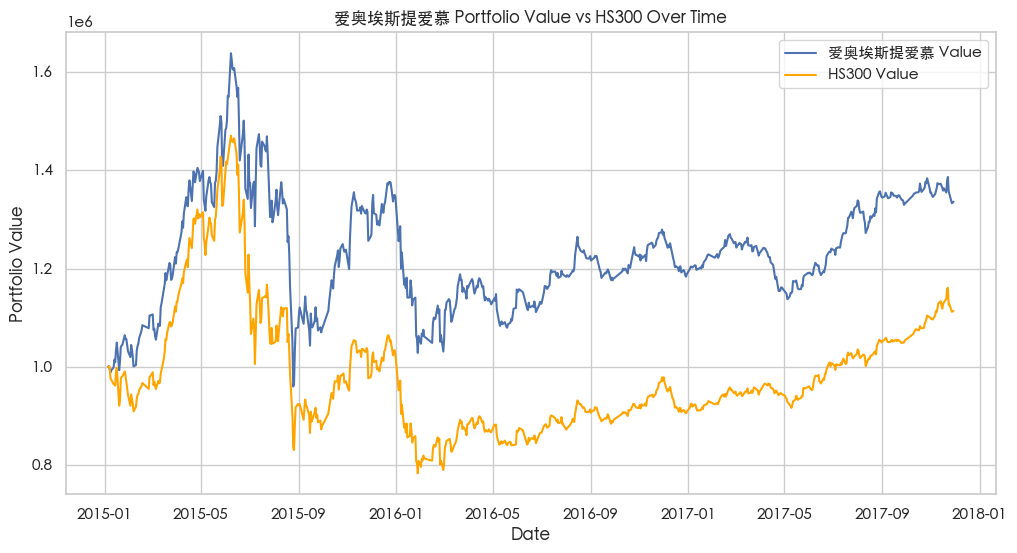

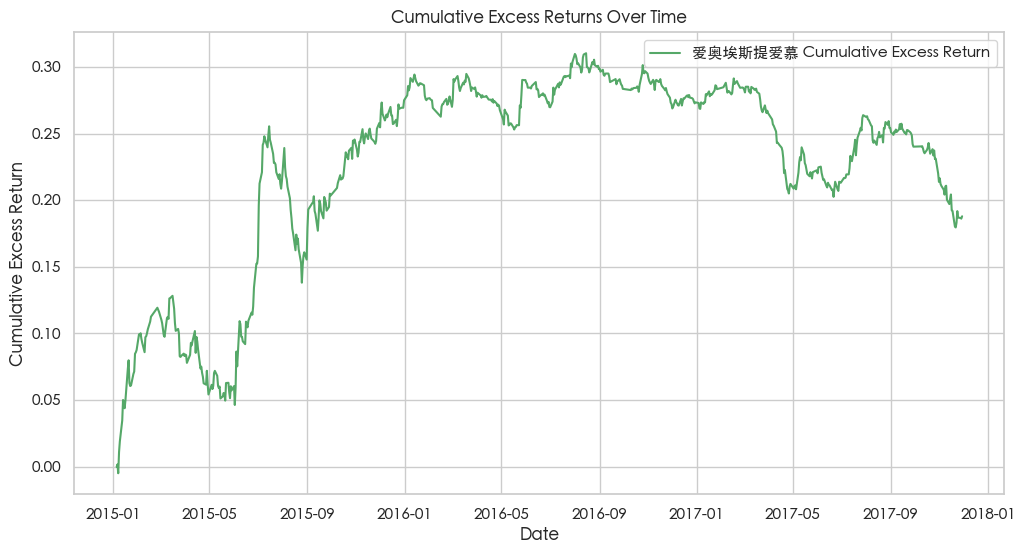

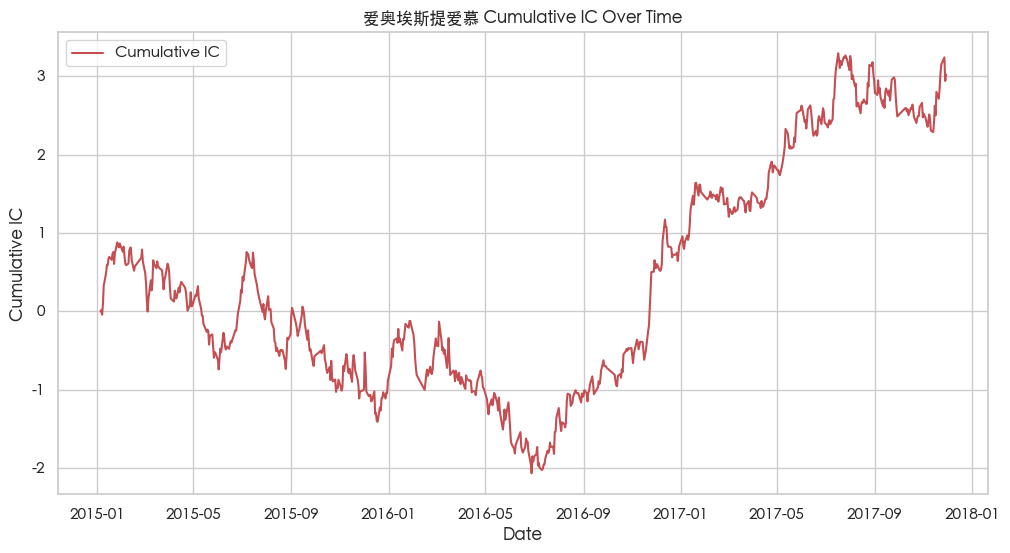

In [188]:
# 初始化数据
rebalance_df = df_lstm

dates = df_lstm.index.get_level_values(0).unique()
rebalance_df = df_lstm.loc[dates[::22]].copy()
close_df = df_close
rebalance_df = df_lstm
# 初始化回测
backtest = Simultrading(
    start_date='2000-10-10',
    end_date='2017-11-30',
    stamp_duty=0.0003,
    brokerage_commission=0.0005,
    start_value=1e+6,
    rebalance_df=pd.DataFrame(rebalance_df['factor']),
    close_df=close_df,
    benchmark="HS300",
    strategy_name='爱奥埃斯提爱慕',
    optimization=  {
            'target': 'MaxSharpeRatio',
            'regularization': None,
            'percent': 0.1,
            'num': None,
            'count': 250,
            'weight_bounds': (0.01, 1)
        },
    TP_SL =  {
            'method': 'fixed_ratio',
            'window_short': 20,
            'window_long': 70,
            'up_pct': 0.3,
            'down_pct': 0.1

        }
    
)

# 开始回测
backtest.run()


In [173]:
a = backtest.rebalance_df.loc['2017-11-22']
a[a['weight']!=0]

,factor,weight
stock_code,,
000100.XSHE,0.858087,0.055680
000338.XSHE,0.829107,0.010000
000415.XSHE,0.835040,0.153939
000625.XSHE,0.818959,0.010000
000627.XSHE,0.920223,0.086751
000671.XSHE,0.825040,0.010000
000961.XSHE,0.878087,0.010000
002146.XSHE,0.856327,0.048758
600000.XSHG,0.940849,0.067757


In [90]:
#现在是单因子回测 分层就是n个实例化的类 然后要分周期算ic（感觉不用跑回测这个） 多头空头 多空组合
#同样 因子df双索引 收盘价数据 然后
#params: 层数num_layer 周期periods 多空组合百分比 回测时间 


In [190]:
from IPython.display import display

@dataclass
class single_factor_test:
    num_layer:int = 5 
    end_date:str = None
    start_date:str = None
    periods: tuple = (1,5,10,20) # 周期分别对应日频周频月频
    factor_df: Optional[pd.DataFrame] = None  #因子数据dataframe 要求双索引 level0是date level1是stock_code 有唯一的因子值列
    close_df: Optional[pd.DataFrame] = None  # 股票收盘价数据 要求列名形式为'000000.XSHG'（与rebalance_df保持一致） index为‘date’ 建议后向填充一下 不填充的话更真实
    percent_ls:float = 0.1 #做多前百分之10 做空后百分之10
    benchmark:str = 'HS300'
    factor_name:str = None
    def __post_init__(self):
        self.factor_df.columns=['factor']
        periods_str = list(map(str, self.periods))
        self.stat_df = pd.DataFrame(index=periods_str, columns=[
            'IC', 'ICIR', 'L&S return', 'L return', 
            'market return', 'L&S Sharpe','L Sharpe', 
            'market Sharpe', 'L&S turnover','L turnover'
        ])
        self.stat_df.index.name = 'holding_period'
        self.df_factor_ls = self.add_weight_ls(self.factor_df)
    
    def resample_df_by_period(self,df: pd.DataFrame, period: int) -> pd.DataFrame:
        # 获取 level 0 索引中的日期并去重
        unique_dates = df.index.get_level_values(0).unique()
        # 每隔 period 选取一个日期
        sampled_dates = unique_dates[::period]
        # 根据选取的日期筛选 df，生成新 DataFrame
        resampled_df = df.loc[sampled_dates]
        return resampled_df
        
    def period_test(self):
        df_factor_long = self.add_weight(self.factor_df, 0)

        # 定义回测函数，以便在并行中调用
        def run_backtest_for_period_strategy(period, strategy_name, rebalance_df):
            backtest_period = Simultrading(
                start_date=self.start_date,
                end_date=self.end_date,
                stamp_duty=0.0,
                brokerage_commission=0.0,
                start_value=1,
                rebalance_df=rebalance_df,
                close_df=self.close_df,
                benchmark=self.benchmark,
                strategy_name=strategy_name
            )
            backtest_period.run()
            
            # 根据策略名称返回所需的指标
            if strategy_name == 'L&S':
                return (period, strategy_name, backtest_period.stat_indicators.iloc[0][['策略年化收益', '年化Sharpe', '总换手/本金']].values)
            elif strategy_name == 'Long':
                return (period, strategy_name, backtest_period.stat_indicators.iloc[0][['策略年化收益', '年化Sharpe', '总换手/本金', '基准年化收益', '基准Sharpe', 'IC', 'ICIR']].values)

        # 并行运行每个周期的每个策略回测任务
        tasks = [(period, 'L&S', self.resample_df_by_period(self.df_factor_ls, period)) for period in self.periods] + \
                [(period, 'Long', self.resample_df_by_period(df_factor_long, period)) for period in self.periods]

        results = Parallel(n_jobs=-1)(delayed(run_backtest_for_period_strategy)(period, strategy_name, rebalance_df) for period, strategy_name, rebalance_df in tasks)
        
        # 将结果写入 stat_df
        for period, strategy_name, metrics in results:
            if strategy_name == 'L&S':
                self.stat_df.loc[str(period), ['L&S return', 'L&S Sharpe', 'L&S turnover']] = metrics
            elif strategy_name == 'Long':
                self.stat_df.loc[str(period), ['L return', 'L Sharpe', 'L turnover', 'market return', 'market Sharpe', 'IC', 'ICIR']] = metrics
        
        # 设置列名为因子名并显示结果
        self.stat_df.columns.name = self.factor_name
        display(self.stat_df)

    '''def period_test(self):
        period_results = {}
        df_factor_long = self.add_weight(0)
        df_factor_equal_weight = self.factor_df.copy()
        df_factor_equal_weight['weight'] = self.factor_df.groupby(level='date').transform(lambda x: 1 / len(x))
        
        def run_backtest_for_period(period):
            df_factor_ls_period = self.resample_df_by_period(self.df_factor_ls, period)
            df_factor_long_period = self.resample_df_by_period(df_factor_long, period)
    
            
            # L&S Backtest
            ls_backtest_period = Simultrading(
                start_date=self.start_date,
                end_date=self.end_date,
                stamp_duty=0.0,
                brokerage_commission=0.0,
                start_value=1,
                rebalance_df=df_factor_ls_period,
                close_df=self.close_df,
                benchmark=self.benchmark,
                strategy_name='L&S'
            )
            ls_backtest_period.run()
            
            # Long Backtest
            long_backtest_period = Simultrading(
                start_date=self.start_date,
                end_date=self.end_date,
                stamp_duty=0.0,
                brokerage_commission=0.0,
                start_value=1,
                rebalance_df=df_factor_long_period,
                close_df=self.close_df,
                benchmark=self.benchmark,
                strategy_name='Long'
            )
            long_backtest_period.run()
            
            
            return {
                'period': period,
                'L&S': ls_backtest_period.stat_indicators.iloc[0][['策略年化收益', '年化Sharpe', '总换手/本金']].values,
                'Long': long_backtest_period.stat_indicators.iloc[0][['策略年化收益', '年化Sharpe', '总换手/本金', '基准年化收益', '基准Sharpe','IC','ICIR']].values
                
            }

        # 使用 joblib 并行执行回测
        results = Parallel(n_jobs=-1)(delayed(run_backtest_for_period)(period) for period in self.periods)
        
        # 将结果写入 stat_df
        for result in results:
            period = result['period']
            self.stat_df.loc[str(period), ['L&S return', 'L&S Sharpe', 'L&S turnover']] = result['L&S']
            self.stat_df.loc[str(period), ['L return', 'L Sharpe', 'L turnover', 'market return', 'market Sharpe','IC','ICIR']] = result['Long']
            self.stat_df.columns.name = self.factor_name
        display(self.stat_df)'''

  
        

    def add_weight(self,df,i):
        """
        创建一个新 DataFrame，包含 'weight' 列，根据因子值按日期分层，第 i 层的股票等权重，其他层权重为 0。
        self.factor_df 必须只有 'factor' 列，并且为双索引 (date, stock_code)。
        """
        # 创建新 DataFrame，包含原始的 'factor' 列，并初始化 'weight' 列为 0
        factor_with_weight = df.copy()

        # 按 date 分组，逐个分组处理
        for date, group in factor_with_weight.groupby(level=0):
            # 按因子值从大到小排序
            sorted_group = group.sort_values(by='factor', ascending=False)

            # 计算每层的大小和分配的起止索引
            layer_size = len(group) // self.num_layer
            start_idx = i * layer_size
            end_idx = start_idx + layer_size if i < self.num_layer - 1 else len(group)

            # 初始化一个权重 Series，默认所有股票权重为 0
            weight_series = pd.Series(0, index=sorted_group.index)

            # 将第 i 层的股票赋予等权重
            if end_idx > start_idx:
                weight_series.iloc[start_idx:end_idx] = 1 / (end_idx - start_idx)

            # 将计算的权重赋值回 `factor_with_weight`
            factor_with_weight.loc[date, 'weight'] = weight_series

        # 确保没有分配权重的股票权重为 0
        factor_with_weight = factor_with_weight.fillna(0.0)
        return factor_with_weight


    def add_weight_ls(self,df, factor_column='factor', top_percent=0.1, bottom_percent=0.1):
        """
        给定的 DataFrame 按照因子列的排序，生成 'weight' 列
        前 top_percent 百分比的股票为正等权重，后 bottom_percent 百分比的股票为负等权重，剩余为 0，确保总权重为 0

        :param df: 要操作的 DataFrame，要求双索引（date, stock_code）
        :param factor_column: 因子列名，默认为 'factor'
        :param top_percent: 前百分之多少赋予正权重，默认为 10%（0.1）
        :param bottom_percent: 后百分之多少赋予负权重，默认为 10%（0.1）
        :return: 更新后的 DataFrame，新增 'weight' 列
        """

        # 创建一个副本，以防修改原数据
        df_copy = df.copy()

        # 按照日期分组处理
        for date, group in df_copy.groupby(level=0):
            # 按因子列从大到小排序
            sorted_group = group.sort_values(by='factor', ascending=False)

            # 获取前后百分比股票的数量
            num_stocks = len(sorted_group)
            top_10_percent = int(np.floor(num_stocks * top_percent))
            bottom_10_percent = int(np.floor(num_stocks * bottom_percent))

            # 初始化权重列为 0
            weight = pd.Series(0, index=sorted_group.index)

            # 为前 top_percent 百分比赋予正的等权重
            if top_10_percent > 0:
                weight.iloc[:top_10_percent] = 1 / top_10_percent

            # 为后 bottom_percent 百分比赋予负的等权重
            if bottom_10_percent > 0:
                weight.iloc[-bottom_10_percent:] = -1 / bottom_10_percent

            # 将权重赋值到 df_copy 的 'weight' 列中
            df_copy.loc[date, 'weight'] = weight

        return df_copy

    def layer_test(self):
        results = {}
        annual_returns = {}

        # 并行计算每一层的回测，包括 L&S 策略
        def run_backtest_layer(i):
            if i == -1:  # 特殊 ID -1 表示 L&S 策略
                backtest = Simultrading(
                    start_date=self.start_date,
                    end_date=self.end_date,
                    stamp_duty=0.0,
                    brokerage_commission=0.0,
                    start_value=1,
                    rebalance_df=self.df_factor_ls,  # 使用 L&S 策略的因子数据
                    close_df=self.close_df,
                    benchmark=self.benchmark,
                    strategy_name='L&S'
                )
            else:
                # 非 -1 的 i 表示其他层
                df_factor_layer = self.add_weight(self.factor_df,i)
                backtest = Simultrading(
                    start_date=self.start_date,
                    end_date=self.end_date,
                    stamp_duty=0.0,
                    brokerage_commission=0.0,
                    start_value=1,
                    rebalance_df=df_factor_layer,
                    close_df=self.close_df,
                    benchmark=self.benchmark,
                    strategy_name=str(i)
                )

            backtest.run()
            return 'L&S' if i == -1 else int(i), backtest.log_df['value'], backtest.stat_indicators['策略年化收益'].iloc[0]

        # 使用 joblib 并行化，包括 L&S 策略（ID 为 -1）
        layers_results = Parallel(n_jobs=-1)(delayed(run_backtest_layer)(i) for i in range(-1, self.num_layer))

        # 将每层结果加入 results 字典，并将每个组合的年化收益作为额外信息
        for key, value, annual_return in layers_results:
            if key == 'L&S':
                percent_key = 'L&S'
            else:
                percent_key = f"{(key/self.num_layer) * 100:.2f}% - {((key+1)/self.num_layer) * 100:.2f}%"
            
            results[percent_key] = value
            annual_returns[percent_key] = annual_return

        # 合并所有层的结果
        df_layer_value = pd.DataFrame(results)

        # 绘图
        plt.figure(figsize=(12, 6))
        for column in df_layer_value.columns:
            # 将组合名称与年化收益组合成图例标签
            label = f"{column} (Annual Return: {annual_returns[column]:.2f}%)"
            plt.plot(df_layer_value.index, df_layer_value[column], label=label)

        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'{self.factor_name} Layer Test P&L')
        plt.legend(title='Layer with Annual Return', prop={'size': 8}, loc='upper left', frameon=True)

        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    '''def layer_test(self):
        
        self.ls_backtest = Simultrading(
            start_date=self.start_date,
            end_date=self.end_date,
            stamp_duty=0.0,
            brokerage_commission=0.0,
            start_value=1,
            rebalance_df=self.df_factor_ls,
            close_df=self.close_df,
            benchmark=self.benchmark,
            strategy_name='L&S'
        )
        self.ls_backtest.run()
        results = {'L&S': self.ls_backtest.log_df['value']}

        # 并行计算每一层的 TestResearcher 回测
        def run_backtest_layer(i):
            df_factor_layer = self.add_weight(i)
            backtest = Simultrading(
                start_date=self.start_date,
                end_date=self.end_date,
                stamp_duty=0.0,
                brokerage_commission=0.0,
                start_value=1,
                rebalance_df=df_factor_layer,
                close_df=self.close_df,
                benchmark=self.benchmark,
                strategy_name=str(i)
            )
            backtest.run()
            return int(i), backtest.log_df['value'] ,backtest.stat_indicators['策略年化收益'].iloc[0]

        # 使用 joblib 并行化
        layers_results = Parallel(n_jobs=-1)(delayed(run_backtest_layer)(i) for i in range(self.num_layer))
        
        # 将每层结果加入 results 字典，并将每个组合的年化收益作为额外信息
        annual_returns = {}
        for key, value, annual_return in layers_results:
            percent_key = f"{key/self.num_layer* 100:.2f}% - {(key+1)/self.num_layer* 100:.2f}%"
            results[percent_key] = value
            annual_returns[percent_key] = annual_return

        # 合并所有层的结果
        df_layer_value = pd.DataFrame(results)

        # 绘图
        plt.figure(figsize=(12, 6))
        for column in df_layer_value.columns:
            # 将组合名称与年化收益组合成图例标签
            label = f"{column} (annual return: {annual_returns[column]:.2f}%)"
            plt.plot(df_layer_value.index, df_layer_value[column], label=label)

        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title('Value Curve for Each Combination')
        plt.legend(title='Combination with Annual Return')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
                '''
    def show_performance(self):
        self.layer_test()
        self.period_test()


   

Processing dates:  88%|████████▊ | 623/710 [00:10<00:01, 64.17it/s]

[INFO] 回测结束, 回测区间为: 2015-01-05 00:00:00 - 2017-11-29 00:00:00
[INFO] 起始资金: 1.00, 结束资金: 1.33
[INFO] 由于手续费以及精度等原因,过程中对目标仓位进行了调整,不过别担心,一共只调整了: 0.00 元
statistical indicators    策略年化收益    基准年化收益  ...      总换手/本金  总手续费/本金
strategy_name                               ...                     
L&S                     0.106089  0.038795  ...  389.003537      0.0

[1 rows x 20 columns]
Figure(1200x600)
Figure(1200x600)
Figure(1200x600)


Processing dates: 100%|██████████| 710/710 [00:11<00:00, 63.10it/s]


[INFO] 回测结束, 回测区间为: 2015-01-05 00:00:00 - 2017-11-29 00:00:00
[INFO] 起始资金: 1.00, 结束资金: 1.29
[INFO] 由于手续费以及精度等原因,过程中对目标仓位进行了调整,不过别担心,一共只调整了: 0.00 元
statistical indicators   策略年化收益    基准年化收益  ...     总换手/本金  总手续费/本金
strategy_name                              ...                    
1                       0.09439  0.038795  ...  316.01587      0.0

[1 rows x 20 columns]
[INFO] 回测结束, 回测区间为: 2015-01-05 00:00:00 - 2017-11-29 00:00:00
[INFO] 起始资金: 1.00, 结束资金: 1.30
[INFO] 由于手续费以及精度等原因,过程中对目标仓位进行了调整,不过别担心,一共只调整了: 0.00 元
statistical indicators    策略年化收益    基准年化收益  ...      总换手/本金  总手续费/本金
strategy_name                               ...                     
2                       0.098447  0.038795  ...  362.981878      0.0

[1 rows x 20 columns]
Figure(1200x600)
Figure(1200x600)
Figure(1200x600)
Figure(1200x600)
Figure(1200x600)
Figure(1200x600)
[INFO] 回测结束, 回测区间为: 2015-01-05 00:00:00 - 2017-11-29 00:00:00
[INFO] 起始资金: 1.00, 结束资金: 1.46
[INFO] 由于手续费以及精度等原因,过程中对目标仓位进行了调整,不过别担心,一共只调整了: 0.00 元
sta

Processing dates:  99%|█████████▊| 700/710 [00:11<00:00, 64.13it/s]

Figure(1200x600)
[INFO] 回测结束, 回测区间为: 2015-01-05 00:00:00 - 2017-11-29 00:00:00
[INFO] 起始资金: 1.00, 结束资金: 0.94
[INFO] 由于手续费以及精度等原因,过程中对目标仓位进行了调整,不过别担心,一共只调整了: 0.00 元
statistical indicators    策略年化收益    基准年化收益  ...      总换手/本金  总手续费/本金
strategy_name                               ...                     
3                      -0.022056  0.038795  ...  287.922373      0.0

[1 rows x 20 columns]
Figure(1200x600)
Figure(1200x600)
Figure(1200x600)


Processing dates: 100%|██████████| 710/710 [00:11<00:00, 61.67it/s]


[INFO] 回测结束, 回测区间为: 2015-01-05 00:00:00 - 2017-11-29 00:00:00
[INFO] 起始资金: 1.00, 结束资金: 1.07
[INFO] 由于手续费以及精度等原因,过程中对目标仓位进行了调整,不过别担心,一共只调整了: 0.00 元
statistical indicators    策略年化收益    基准年化收益  ...      总换手/本金  总手续费/本金
strategy_name                               ...                     
4                       0.023742  0.038795  ...  149.247551      0.0

[1 rows x 20 columns]
Figure(1200x600)
Figure(1200x600)
Figure(1200x600)


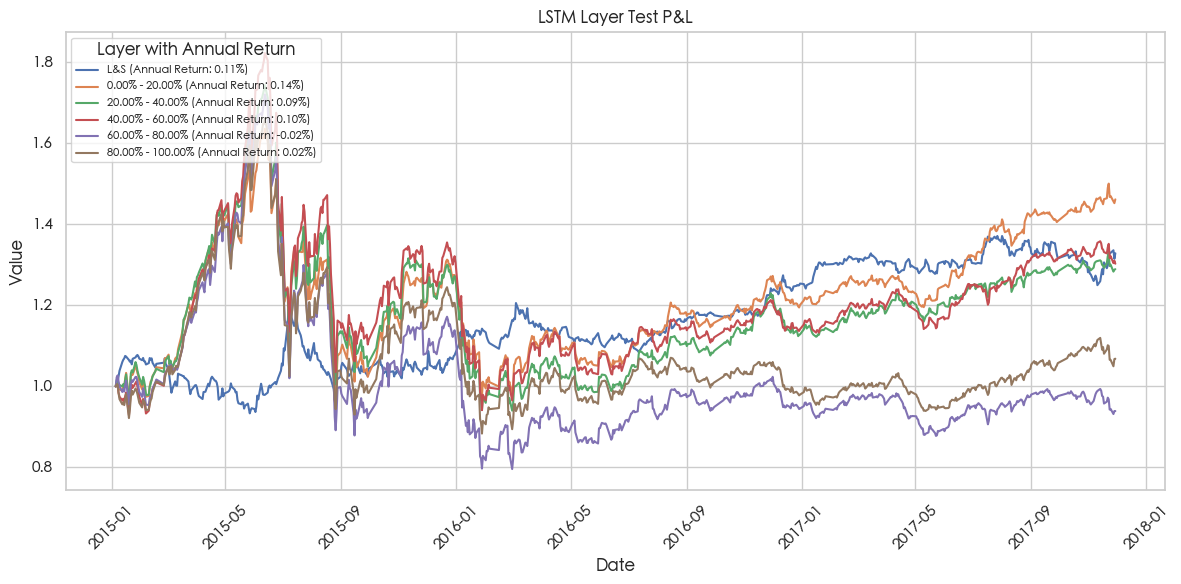

Processing dates:  87%|████████▋ | 617/706 [00:09<00:01, 75.11it/s]

[INFO] 回测结束, 回测区间为: 2015-01-05 00:00:00 - 2017-11-16 00:00:00
[INFO] 起始资金: 1.00, 结束资金: 1.35
[INFO] 由于手续费以及精度等原因,过程中对目标仓位进行了调整,不过别担心,一共只调整了: 0.00 元
statistical indicators    策略年化收益    基准年化收益  ...     总换手/本金  总手续费/本金
strategy_name                               ...                    
Long                    0.113451  0.044008  ...  29.499471      0.0

[1 rows x 20 columns]
Figure(1200x600)
Figure(1200x600)
Figure(1200x600)
[INFO] 回测结束, 回测区间为: 2015-01-05 00:00:00 - 2017-11-16 00:00:00
[INFO] 起始资金: 1.00, 结束资金: 1.43
[INFO] 由于手续费以及精度等原因,过程中对目标仓位进行了调整,不过别担心,一共只调整了: 0.00 元
statistical indicators    策略年化收益    基准年化收益  ...     总换手/本金  总手续费/本金
strategy_name                               ...                    
L&S                     0.137765  0.044008  ...  76.552676      0.0

[1 rows x 20 columns]
Figure(1200x600)
Figure(1200x600)
[INFO] 回测结束, 回测区间为: 2015-01-05 00:00:00 - 2017-11-16 00:00:00
[INFO] 起始资金: 1.00, 结束资金: 1.30
[INFO] 由于手续费以及精度等原因,过程中对目标仓位进行了调整,不过别担心,一共只调整了: 0.00 元
Figure(1200x600)
sta

Processing dates:  90%|████████▉ | 635/706 [00:09<00:00, 79.08it/s]

Figure(1200x600)
Figure(1200x600)
Figure(1200x600)
[INFO] 回测结束, 回测区间为: 2015-01-05 00:00:00 - 2017-11-16 00:00:00
[INFO] 起始资金: 1.00, 结束资金: 1.40
[INFO] 由于手续费以及精度等原因,过程中对目标仓位进行了调整,不过别担心,一共只调整了: 0.00 元
statistical indicators    策略年化收益    基准年化收益  ...    总换手/本金  总手续费/本金
strategy_name                               ...                   
Long                    0.128476  0.044008  ...  42.87398      0.0

[1 rows x 20 columns]


Processing dates:  91%|█████████ | 643/706 [00:09<00:00, 64.86it/s]

Figure(1200x600)
Figure(1200x600)
Figure(1200x600)


Processing dates:  99%|█████████▉| 702/706 [00:10<00:00, 88.35it/s]

[INFO] 回测结束, 回测区间为: 2015-01-05 00:00:00 - 2017-11-23 00:00:00
[INFO] 起始资金: 1.00, 结束资金: 1.36
[INFO] 由于手续费以及精度等原因,过程中对目标仓位进行了调整,不过别担心,一共只调整了: 0.00 元
statistical indicators    策略年化收益    基准年化收益  ...      总换手/本金  总手续费/本金
strategy_name                               ...                     
L&S                     0.115055  0.043452  ...  160.700617      0.0

[1 rows x 20 columns]
Figure(1200x600)
Figure(1200x600)
Figure(1200x600)


Processing dates:  61%|██████    | 433/710 [00:09<00:04, 64.35it/s]

[INFO] 回测结束, 回测区间为: 2015-01-05 00:00:00 - 2017-11-23 00:00:00
[INFO] 起始资金: 1.00, 结束资金: 1.46
[INFO] 由于手续费以及精度等原因,过程中对目标仓位进行了调整,不过别担心,一共只调整了: 0.00 元
statistical indicators    策略年化收益    基准年化收益  ...    总换手/本金  总手续费/本金
strategy_name                               ...                   
Long                    0.144616  0.043452  ...  65.24942      0.0

[1 rows x 20 columns]
Figure(1200x600)
Figure(1200x600)
Figure(1200x600)


Processing dates: 100%|██████████| 710/710 [00:13<00:00, 52.72it/s]


[INFO] 回测结束, 回测区间为: 2015-01-05 00:00:00 - 2017-11-29 00:00:00
[INFO] 起始资金: 1.00, 结束资金: 1.33
[INFO] 由于手续费以及精度等原因,过程中对目标仓位进行了调整,不过别担心,一共只调整了: 0.00 元
[INFO] 回测结束, 回测区间为: 2015-01-05 00:00:00 - 2017-11-29 00:00:00
[INFO] 起始资金: 1.00, 结束资金: 1.46
[INFO] 由于手续费以及精度等原因,过程中对目标仓位进行了调整,不过别担心,一共只调整了: 0.00 元
statistical indicators    策略年化收益    基准年化收益  ...      总换手/本金  总手续费/本金
strategy_name                               ...                     
L&S                     0.106089  0.038795  ...  389.003537      0.0

[1 rows x 20 columns]
statistical indicators    策略年化收益    基准年化收益  ...      总换手/本金  总手续费/本金
strategy_name                               ...                     
Long                    0.144221  0.038795  ...  157.212251      0.0

[1 rows x 20 columns]
Figure(1200x600)
Figure(1200x600)
Figure(1200x600)
Figure(1200x600)
Figure(1200x600)
Figure(1200x600)


LSTM,IC,ICIR,L&S return,L return,market return,L&S Sharpe,L Sharpe,market Sharpe,L&S turnover,L turnover
holding_period,,,,,,,,,,
1,0.004254,0.037895,0.106089,0.144221,0.038795,0.697531,0.506606,0.143705,389.003537,157.212251
5,0.015691,0.14279,0.115055,0.144616,0.043452,0.757752,0.507197,0.160574,160.700617,65.24942
10,0.022913,0.224186,0.0999,0.128476,0.044008,0.655268,0.454976,0.162546,105.932888,42.87398
20,0.035929,0.345242,0.137765,0.113451,0.044008,0.870648,0.398852,0.162546,76.552676,29.499471


In [191]:
single_factor = single_factor_test(
    num_layer = 5, 
    end_date = None,
    start_date = None,
    periods= (1,5,10,20), # 周期分别对应日频周频月频
    factor_df = pd.DataFrame(df_lstm.iloc[:,0]) , #因子数据dataframe 要求双索引 level0是date level1是stock_code 有唯一的因子值列
    close_df = df_close  ,# 股票收盘价数据 要求列名形式为'000000.XSHG'（与rebalance_df保持一致） index为‘date’ 建议后向填充一下 不填充的话更真实
    percent_ls = 0.1,
    factor_name= 'LSTM')
single_factor.show_performance()

In [ ]:
def add_weight(df, percent: float):
    """
    创建一个新 DataFrame，包含 'weight' 列，根据因子值按日期分层，
    选取每个日期的前 percent 的股票等权重，其他股票权重为 0。
    self.factor_df 必须只有 'factor' 列，并且为双索引 (date, stock_code)。
    
    参数:
    percent (float): 表示选取前百分之多少的股票分配等权重 (例如: 0.2 表示前20%)
    """
    # 创建新 DataFrame，包含原始的 'factor' 列，并初始化 'weight' 列为 0
    factor_with_weight = df.copy()
    factor_with_weight.columns = ['factor']
    factor_with_weight['weight'] = 0.0

    # 按 date 分组，逐个分组处理
    for date, group in factor_with_weight.groupby(level=0):
        # 按因子值从大到小排序
        sorted_group = group.sort_values(by='factor', ascending=False)

        # 计算前 percent 部分的股票数量
        num_selected = int(len(group) * percent)
        
        # 如果 percent 太小，确保至少选择一个
        if num_selected < 1:
            num_selected = 1

        # 计算等权重
        weight = 1 / num_selected if num_selected > 0 else 0

        # 将前 percent 的股票赋予等权重，并在新 DataFrame 中更新
        selected_stocks = sorted_group.index[:num_selected].get_level_values(1)
        factor_with_weight.loc[(date, selected_stocks), 'weight'] = weight

    # 填充 NaN 值为 0.0
    factor_with_weight = factor_with_weight.fillna(0.0)

    return factor_with_weight 